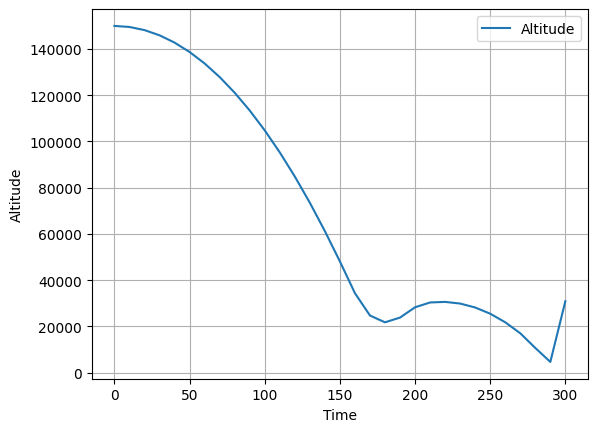

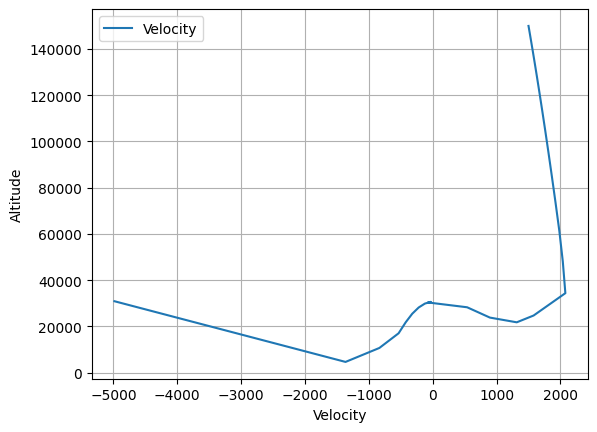

Angle of Attack 17
Lift force value 1359170.480715789
Drift Force Value 756333.5482678349


In [4]:

#     The main aim is to control the flight path of the vehicle throughout
#     the reentry phase with safety bounds.
# 
#     To meet the objective, the states r, V , γ , φ , θ , ψ are considered,
#     with their dynamics given by the following equations and
#     with α as a control variable.
# 
#     ṙ = V sinγ
# 
#           D
#     V̇ = − - − g sinγ + Ωe^2 r cosφ( cosφ sinγ − cosγ sinφ sinψ)
#           m
# 
#         L cosσ   g        V           
#     γ̇ = ------ − - cosγ + - cosγ + 2 Ωe cosφ cosψ 
#          mV      V        r      
#          
#             Ωe^2 r
#          +  ------ cosφ( cosγ cosφ + sinγ sinφ sinψ)
#               V
# 
#           V cosγ sinψ
#     φ̇ =   -----------
#               r
# 
# 
#           V cosγ cosψ
#     θ̇ =   -----------
#             r cosφ
# 
#           L sinσ    V
#     ψ̇ =   ------  − - (cosγ cosψ tanφ)
#           mV cosγ   r
# 
#           + 2 Ωe ( tanγ cosφ sinψ − sin φ)
#              Ωe^2 r
#           −  ------ (sinφ cosφ cosψ)
#              V cosγ
# 
#     where 
#     r is the radial distance from the center of the Earth to the vehicle, 
#     V is the earth relative velocity, 
#     Ωe is the earth angular speed, 
#     γ is the flight path angle, 
#     σ is the bank angle, 
#     ψ is the heading angle, 
#     m is the mass of the vehicle, 
#     g is the acceleration due to gravity, 
#     φ and θ are the latitude and longitude respectively.
# 
# 
#     The guidance command is supposed to guide the vehicle through the flight corridor,
#     dictated by the following path constraints:
# 
#     (1) Heat flux constraint, q < 18.5 W/cm^2
#     (2) Dynamic pressure, Q < 45 kPa
#
#     Author: ravi_ram
#
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sci

from rlv_sso import optimizer
from rlv_empirical_data import database
num_particles = 15
max_iter = 100
runs = 1
Elite_agents = 7
Inferior_agents = num_particles - Elite_agents

# constants
deg    = math.pi/180   # convert degrees to radians
g0     = 9.81          # sea-level acceleration of gravity (m/s)
Re     = 6378e3        # radius of the earth (m)
rho0   = 1.225         # sea level density of atmosphere (kg/m^3)

R = 287.4              # specific gas constant for air
K = 1.4                # ratio of specific heat of a gas at a constant pressure to heat at a constant volume (1.4 for air)
T0 = 288.15            # K standard temperature at sea level

# RLV values
Rn     = 0.25          # nose radius (m)
Mo     = 1750          # Mass at orbit (kg)
Mp     = 300           # Mass Mass of propellant (kg)
m = Mo + Mp            # total mass

# aerodynamic constant
S      = 0.785         # frontal area, m^2
k      = 0.18          # aerodynamic constant, 0.03

# control variable
alpha  = 0.0           # to be optimized from genetic
sigma  = 0.0           # bank angle assumed 0

# initial conditions:
h0, v0, gamma0, lamda0, phi0, psi0 = 150000,1500,0,0,0,0

# initial conditions vector:
f0 = [h0, v0, gamma0, lamda0, phi0, psi0]
          
# alpha, L, D
c0 = [alpha, 0, 0] 

# orbiter data
orb_data = [Rn, m, rho0]

# heat constants
tem_data = [R, K, T0]

# aerodynamic constants
aero_data = [S, k]

# equations of motion for a lifting trajectory
def ode_functions(t, y, *args):
    # args from genetic optimizer
    alpha, L, D = args
    
    # output as col vector
    dydt = np.zeros(6)
    # compute angles (lambda is python function)
    [h, v, gamma, lamda, phi, psi] = y
    s_phi = np.sin(phi);     c_phi = np.cos(phi);
    s_gamma = np.sin(gamma); c_gamma = np.cos(gamma);
    s_psi = np.sin(psi);     c_psi = np.cos(psi);
    c_lamda = np.cos(lamda); s_lamda = np.sin(lamda);
    c_alpha = np.cos(alpha); s_alpha = np.sin(alpha);    
    c_sigma = np.cos(sigma); s_sigma = np.sin(sigma);

    g = g0/(1 + h/Re)**2     # gravity with altitude h  
    r = Re + h               # radial vector (m)

    T = 0.0      # Thrust = 0, placeholder for future
    
    # equations of motion for a lifting trajectory
    h_dot = v * s_gamma    
    v_dot = - g * s_gamma + ( (T * c_alpha - D) / m)
    gamma_dot = (v / r - g / v) * c_gamma  + (L  + T * s_alpha) / (m * v) * c_sigma
    psi_dot =  -(v/r) * c_gamma * c_psi * (s_phi / c_phi) + (L  + T * s_alpha)/(m * v) * s_sigma / c_gamma
    lamda_dot = v / r * (c_gamma * c_psi) / c_phi
    phi_dot = v / r * c_gamma * s_psi    
    # pack derivative in output vector
    dydt[0]  = h_dot
    dydt[1]  = v_dot
    dydt[2]  = gamma_dot
    dydt[3]  = lamda_dot
    dydt[4]  = phi_dot
    dydt[5]  = psi_dot
    return dydt  


# plot results
def plot(times, Y):
    # split the result into columns
    cols = list(zip(*Y))

    # plot
    fig = plt.figure()
    plt1 = plt.plot(times, cols[0], label="Altitude")
    plt.xlabel("Time")
    plt.ylabel("Altitude")
    plt.legend()
    plt.grid()
    plt.show()

    plt2 = plt.plot(cols[1], cols[0], label="Velocity")
    plt.xlabel("Velocity")
    plt.ylabel("Altitude")
    plt.legend()
    plt.grid()
    plt.show()
    
    return
    
# main function
if __name__ == "__main__":

    # initilize genetic optimizer
    opt = optimizer()
    
    Y = []       # [h, v, gamma, lamda, phi, psi]
    Y.append(f0) # start position
    
    control = [] # [alpha, L, D]
    control.append(c0)

    # integration time step 
    endtime = 300; t_step = 10;
    
    # list of time steps 
    times = np.linspace(0, endtime, int(endtime / t_step) + 1)
    
    # integrate
    for t_start, t_end in zip(times, times[1:]):
        # ode integration period
        t_span = [t_start, t_end]
        
        # current init = previous last
        f0 = Y[-1]
        
        # optimize alpha for the given constraints
        alpha_new, L_new, D_new = opt.get_values(Y, control, orb_data, tem_data, aero_data)

        # pack args list
        args = [alpha_new, L_new, D_new]
        control.append(args)
        
        # solve next ode step
        answer = sci.solve_ivp(ode_functions, t_span, f0, args=args)
        
        # create new input for next iteration
        x = [answer.y[i][-1] for i in range(len(f0))]
        
        # solution list
        Y.append(x)

    # plot the results
    plot(times, Y)
    print('Angle of Attack',alpha_new)
    print('Lift force value', L_new)
    print('Drift Force Value', D_new)
    
    

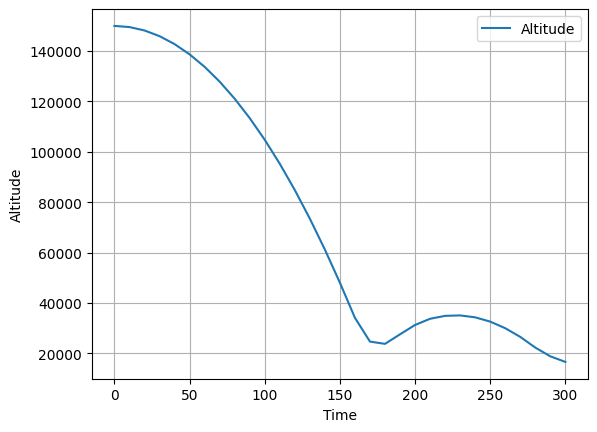

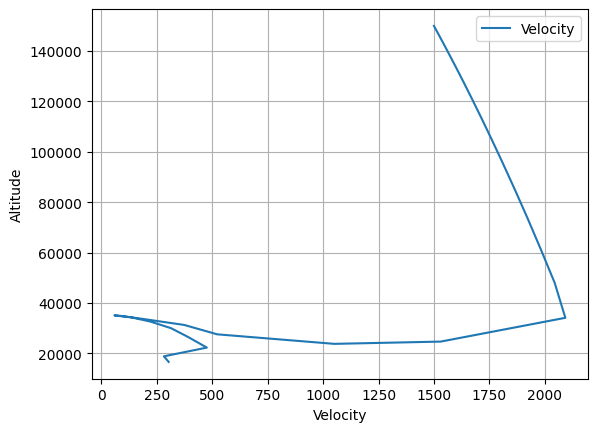

Angle of Attack 11
Lift force value 15231.847722655159
Drift Force Value 10779.154984693721


In [1]:

#     The main aim is to control the flight path of the vehicle throughout
#     the reentry phase with safety bounds.
# 
#     To meet the objective, the states r, V , γ , φ , θ , ψ are considered,
#     with their dynamics given by the following equations and
#     with α as a control variable.
# 
#     ṙ = V sinγ
# 
#           D
#     V̇ = − - − g sinγ + Ωe^2 r cosφ( cosφ sinγ − cosγ sinφ sinψ)
#           m
# 
#         L cosσ   g        V           
#     γ̇ = ------ − - cosγ + - cosγ + 2 Ωe cosφ cosψ 
#          mV      V        r      
#          
#             Ωe^2 r
#          +  ------ cosφ( cosγ cosφ + sinγ sinφ sinψ)
#               V
# 
#           V cosγ sinψ
#     φ̇ =   -----------
#               r
# 
# 
#           V cosγ cosψ
#     θ̇ =   -----------
#             r cosφ
# 
#           L sinσ    V
#     ψ̇ =   ------  − - (cosγ cosψ tanφ)
#           mV cosγ   r
# 
#           + 2 Ωe ( tanγ cosφ sinψ − sin φ)
#              Ωe^2 r
#           −  ------ (sinφ cosφ cosψ)
#              V cosγ
# 
#     where 
#     r is the radial distance from the center of the Earth to the vehicle, 
#     V is the earth relative velocity, 
#     Ωe is the earth angular speed, 
#     γ is the flight path angle, 
#     σ is the bank angle, 
#     ψ is the heading angle, 
#     m is the mass of the vehicle, 
#     g is the acceleration due to gravity, 
#     φ and θ are the latitude and longitude respectively.
# 
# 
#     The guidance command is supposed to guide the vehicle through the flight corridor,
#     dictated by the following path constraints:
# 
#     (1) Heat flux constraint, q < 18.5 W/cm^2
#     (2) Dynamic pressure, Q < 45 kPa
#
#     Author: ravi_ram
#
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sci
from rlv_genetic_optimizer import optimizer
from rlv_empirical_data import database

# constants
deg    = math.pi/180   # convert degrees to radians
g0     = 9.81          # sea-level acceleration of gravity (m/s)
Re     = 6378e3        # radius of the earth (m)
rho0   = 1.225         # sea level density of atmosphere (kg/m^3)

R = 287.4              # specific gas constant for air
K = 1.4                # ratio of specific heat of a gas at a constant pressure to heat at a constant volume (1.4 for air)
T0 = 288.15            # K standard temperature at sea level

# RLV values
Rn     = 0.25          # nose radius (m)
Mo     = 1750          # Mass at orbit (kg)
Mp     = 300           # Mass Mass of propellant (kg)
m = Mo + Mp            # total mass

# aerodynamic constant
S      = 0.785         # frontal area, m^2
k      = 0.18          # aerodynamic constant, 0.03

# control variable
alpha  = 0.0           # to be optimized from genetic
sigma  = 0.0           # bank angle assumed 0

# initial conditions:
h0, v0, gamma0, lamda0, phi0, psi0 = 150000,1500,0,0,0,0

# initial conditions vector:
f0 = [h0, v0, gamma0, lamda0, phi0, psi0]
          
# alpha, L, D
c0 = [alpha, 0, 0] 

# orbiter data
orb_data = [Rn, m, rho0]

# heat constants
tem_data = [R, K, T0]

# aerodynamic constants
aero_data = [S, k]

# equations of motion for a lifting trajectory
def ode_functions(t, y, *args):
    # args from genetic optimizer
    alpha, L, D = args
    
    # output as col vector
    dydt = np.zeros(6)
    # compute angles (lambda is python function)
    [h, v, gamma, lamda, phi, psi] = y
    s_phi = np.sin(phi);     c_phi = np.cos(phi);
    s_gamma = np.sin(gamma); c_gamma = np.cos(gamma);
    s_psi = np.sin(psi);     c_psi = np.cos(psi);
    c_lamda = np.cos(lamda); s_lamda = np.sin(lamda);
    c_alpha = np.cos(alpha); s_alpha = np.sin(alpha);    
    c_sigma = np.cos(sigma); s_sigma = np.sin(sigma);

    g = g0/(1 + h/Re)**2     # gravity with altitude h  
    r = Re + h               # radial vector (m)

    T = 0.0      # Thrust = 0, placeholder for future
    
    # equations of motion for a lifting trajectory
    h_dot = v * s_gamma    
    v_dot = - g * s_gamma + ( (T * c_alpha - D) / m)
    gamma_dot = (v / r - g / v) * c_gamma  + (L  + T * s_alpha) / (m * v) * c_sigma
    psi_dot =  -(v/r) * c_gamma * c_psi * (s_phi / c_phi) + (L  + T * s_alpha)/(m * v) * s_sigma / c_gamma
    lamda_dot = v / r * (c_gamma * c_psi) / c_phi
    phi_dot = v / r * c_gamma * s_psi    
    # pack derivative in output vector
    dydt[0]  = h_dot
    dydt[1]  = v_dot
    dydt[2]  = gamma_dot
    dydt[3]  = lamda_dot
    dydt[4]  = phi_dot
    dydt[5]  = psi_dot
    return dydt  


# plot results
def plot(times, Y):
    # split the result into columns
    cols = list(zip(*Y))

    # plot
    fig = plt.figure()
    plt1 = plt.plot(times, cols[0], label="Altitude")
    plt.xlabel("Time")
    plt.ylabel("Altitude")
    plt.legend()
    plt.grid()
    plt.show()

    plt2 = plt.plot(cols[1], cols[0], label="Velocity")
    plt.xlabel("Velocity")
    plt.ylabel("Altitude")
    plt.legend()
    plt.grid()
    plt.show()
    
    return
    
# main function
if __name__ == "__main__":

    # initilize genetic optimizer
    opt = optimizer()
    
    Y = []       # [h, v, gamma, lamda, phi, psi]
    Y.append(f0) # start position
    
    control = [] # [alpha, L, D]
    control.append(c0)

    # integration time step 
    endtime = 300; t_step = 10;
    
    # list of time steps 
    times = np.linspace(0, endtime, int(endtime / t_step) + 1)
    
    # integrate
    for t_start, t_end in zip(times, times[1:]):
        # ode integration period
        t_span = [t_start, t_end]
        
        # current init = previous last
        f0 = Y[-1]
        
        # optimize alpha for the given constraints
        alpha_new, L_new, D_new = opt.get_values(Y, control, orb_data, tem_data, aero_data)

        # pack args list
        args = [alpha_new, L_new, D_new]
        control.append(args)
        
        # solve next ode step
        answer = sci.solve_ivp(ode_functions, t_span, f0, args=args)
        
        # create new input for next iteration
        x = [answer.y[i][-1] for i in range(len(f0))]
        
        # solution list
        Y.append(x)

    # plot the results
    plot(times, Y)
    print('Angle of Attack',alpha_new)
    print('Lift force value', L_new)
    print('Drift Force Value', D_new)
    
    

In [6]:
pip install PyGWO

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement PyGWO (from versions: none)
ERROR: No matching distribution found for PyGWO
